In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
from dataset import CustomImageDataset
from torch.utils.data import DataLoader
from skimage import exposure
from skimage.exposure import match_histograms
import ImageProcessing as IP
import torchvision.transforms as transforms

Testing creating custom dataset

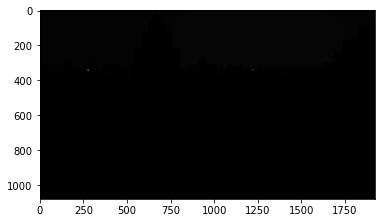

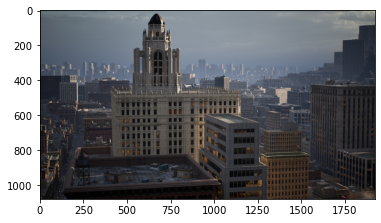

In [18]:
data = CustomImageDataset(img_dir='./Sample RGB/', depth_dir='./Sample Depth/')
data_loader = DataLoader(data, batch_size=1, shuffle=True) #Loads a random RGB, Depth couple from the dataset
rgb_img, depth_img = next(iter(data_loader)) #Unsqueezes and converts to tensor, may need to squeeze(0)
plt.imshow(depth_img[0], cmap='gray')
plt.show()
plt.imshow(rgb_img[0])
plt.show()

In [19]:
rgb_img[0].shape

torch.Size([1080, 1920, 3])

Testing transforming RGB images